In [ ]:
# Import necessary packages

import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import norm
import math
import seaborn as sns
from tqdm import tqdm
import scipy.stats as stats


Loan de Traversay & Julien Dos Reis

## Import Data

In [ ]:
# Set tickers to download
liste_company = [
    "APPLE",
    "GOOGLE",
    "AMAZON"
]
liste_tickers_to_download = [
    "AAPL",
    "GOOG",
    "AMZN"
]


# Function to download data historic by their tickers name
def download_data(ticker_name, company_name):
    data_ticker = yf.download(
        tickers=ticker_name,
        start="2021-05-03",
        end="2023-05-03",  # time period
        interval="1d",  # trading interval
        ignore_tz=True,  # ignore timezone when aligning data from different exchanges?
        prepost=False)  # download pre/post market hours data?

    # keep only the close price, and rename the column by the ticker name
    df = data_ticker[['Close']]
    df = df.rename(columns={'Close': company_name})
    df.reset_index(inplace=True)

    # Keep only last price of each month and compute returns
    df = df.reset_index(drop=True)
    df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')

    return (df)

In [ ]:
liste_df = []
for n in range(0, len(liste_tickers_to_download)):
    exec(
        f"df_{n} = download_data(liste_tickers_to_download[n], liste_company[n])")
    liste_df.append('df_'+str(n))
df_0

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Date,APPLE
0,2021-05-03,132.539993
1,2021-05-04,127.849998
2,2021-05-05,128.100006
3,2021-05-06,129.740005
4,2021-05-07,130.210007
...,...,...
499,2023-04-26,163.759995
500,2023-04-27,168.410004
501,2023-04-28,169.679993
502,2023-05-01,169.589996


## Prepare Data

In [ ]:
prices = pd.concat([df_0['APPLE'], df_1['GOOGLE'], df_2['AMAZON']], axis=1, keys=['APPLE', 'GOOGLE', 'AMAZON'])
prices = prices.set_index(df_0["Date"])
prices

,APPLE,GOOGLE,AMAZON
Date,,,
2021-05-03,132.539993,119.758499,169.324493
2021-05-04,127.849998,117.712502,165.593506
2021-05-05,128.100006,117.836998,163.526993
2021-05-06,129.740005,119.067497,165.318497
2021-05-07,130.210007,119.934502,164.580505
...,...,...,...
2023-04-26,163.759995,104.449997,104.980003
2023-04-27,168.410004,108.370003,109.820000
2023-04-28,169.679993,108.220001,105.449997


In [ ]:
LogReturns = np.log(prices/prices.shift()).dropna()
LogReturns

,APPLE,GOOGLE,AMAZON
Date,,,
2021-05-04,-0.036027,-0.017232,-0.022281
2021-05-05,0.001954,0.001057,-0.012558
2021-05-06,0.012721,0.010388,0.010896
2021-05-07,0.003616,0.007255,-0.004474
2021-05-10,-0.026143,-0.024063,-0.031202
...,...,...,...
2023-04-26,-0.000061,-0.001531,0.023224
2023-04-27,0.028000,0.036843,0.045073
2023-04-28,0.007513,-0.001385,-0.040606


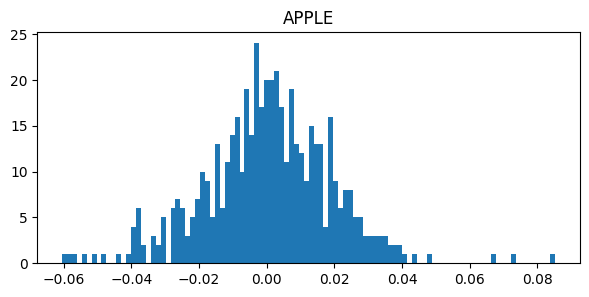

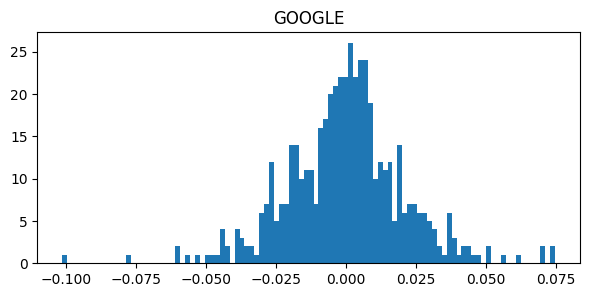

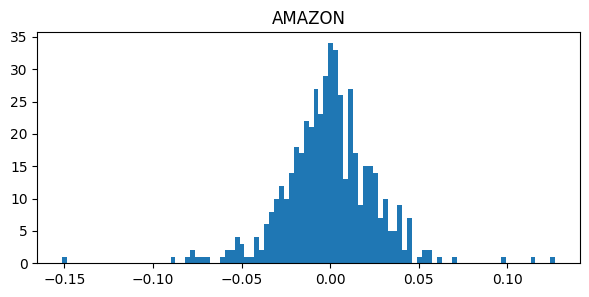

In [ ]:

def visualize(col):
  plt.figure(figsize=(7,3))    
  plt.hist(x = LogReturns[col], bins = 100)
  plt.title(col)
for col in LogReturns:
    visualize(col)

In [ ]:
# create a portfolio with equal weights
weights = [1/3, 1/3, 1/3]

portofolioPrices = (prices * weights).sum(axis=1)
print(portofolioPrices)

portofolioReturns = (LogReturns * weights).sum(axis=1)
print(portofolioReturns)

Date
2021-05-03    140.540995
2021-05-04    137.052002
2021-05-05    136.487999
2021-05-06    138.042000
2021-05-07    138.241671
                 ...    
2023-04-26    124.396665
2023-04-27    128.866669
2023-04-28    127.783330
2023-05-01    126.449999
2023-05-02    126.049998
Length: 504, dtype: float64
Date
2021-05-04   -0.025180
2021-05-05   -0.003182
2021-05-06    0.011335
2021-05-07    0.002132
2021-05-10   -0.027136
                ...   
2023-04-26    0.007211
2023-04-27    0.036638
2023-04-28   -0.011493
2023-05-01   -0.012676
2023-05-02   -0.002346
Length: 503, dtype: float64


In [ ]:
# We can now calculate the variance of the portofolio

mean_ptf = sum(portofolioReturns) / len(portofolioReturns)
squared_diffs = 0
for x in portofolioReturns:
    squared_diffs += (x - mean_ptf) ** 2
    
variance_ptf = squared_diffs / (len(portofolioReturns) - 1)
print(variance_ptf)
std_ptf = variance_ptf**0.5
print(std_ptf)

# This standard deviation is calculated on a daily basis
# Since we took daily returns, we expect an integer : 252 for annual and 52 for weekly
# For a daily frequency, we don't change anything ==> freq = 1
freq = 1
volatility = std_ptf*np.sqrt(freq)

0.0003812851295583917
0.019526523744855143


# 2.1 Parametric approach

## Simple Moving Average (SMA) Method :

The SMA approach gives equal importance to all observations used in the look back period and does
not account for the fact that information tends to decay or become less relevant over time.

In [ ]:
# Compute the quantile function of the normal distribution
confidence = 1/100

def Z_(d):
    return norm.ppf(1 - d)

z_value = Z_(confidence)
z_value

2.3263478740408408

In [ ]:
def VaR_SMA(df):
  VaR_X = z_value*volatility
  VaR_Dollar = list(df.values)[-1]*VaR_X

  return [VaR_X, VaR_Dollar]

SMA_var =  round(VaR_SMA(portofolioPrices)[0]*100, 2)
SMA_var_doll = round(VaR_SMA(portofolioPrices)[1], 2)

print("There is a", confidence*100,"% probability that, on any given day, the loss in value on this particular asset will equal or exceed", 
     SMA_var,"% or $", SMA_var_doll)



There is a 1.0 % probability that, on any given day, the loss in value on this particular asset will equal or exceed 4.54 % or $ 5.73


## Exponentially Weighted Moving Average (EWMA) Method :

The
EWMA method, on the other hand, gives more importance to recent information and hence places
greater weight on more recent returns. This is achieved by specifying a parameter, Lambda, (0< λ <1) and placing exponentially declining weights on historical data.

In [ ]:
# We need to weights the lambda to make oldest obeservations less important
# The thing is, our dataset is built in a way that our first obeservation is the oldest one
# So we build with np.arange a list of weights that we will apply to our lambda

weight = np.arange(len(portofolioReturns)-1, -1, -1)
# There is 503 observations in our returns dataset
# We set our function such as it starts at the max length minus 1 (=502)
# It then ends at 0 and it goes from 502 to 0 with a step of -1

# By doing so, our first EWMA value will be 
# ==> (1 - lambda) * lambda**(502) * returns**2
# Which makes it way less important than our last EWMA that will be:
# ==> (1 - lambda) * lambda**(0) * returns**2 = (1 - lambda) * returns**2
weight

array([502, 501, 500, 499, 498, 497, 496, 495, 494, 493, 492, 491, 490,
       489, 488, 487, 486, 485, 484, 483, 482, 481, 480, 479, 478, 477,
       476, 475, 474, 473, 472, 471, 470, 469, 468, 467, 466, 465, 464,
       463, 462, 461, 460, 459, 458, 457, 456, 455, 454, 453, 452, 451,
       450, 449, 448, 447, 446, 445, 444, 443, 442, 441, 440, 439, 438,
       437, 436, 435, 434, 433, 432, 431, 430, 429, 428, 427, 426, 425,
       424, 423, 422, 421, 420, 419, 418, 417, 416, 415, 414, 413, 412,
       411, 410, 409, 408, 407, 406, 405, 404, 403, 402, 401, 400, 399,
       398, 397, 396, 395, 394, 393, 392, 391, 390, 389, 388, 387, 386,
       385, 384, 383, 382, 381, 380, 379, 378, 377, 376, 375, 374, 373,
       372, 371, 370, 369, 368, 367, 366, 365, 364, 363, 362, 361, 360,
       359, 358, 357, 356, 355, 354, 353, 352, 351, 350, 349, 348, 347,
       346, 345, 344, 343, 342, 341, 340, 339, 338, 337, 336, 335, 334,
       333, 332, 331, 330, 329, 328, 327, 326, 325, 324, 323, 32

In [ ]:
# Now that we're aware of this, we can set our function

# We set a lambda value
lambda_param = 0.89

# We can now compute the variance and std
def EWMA_method(lambda_param, df):
  weight = np.arange(len(df)-1, -1, -1)
  decay = (1 - lambda_param) * (lambda_param**weight)
  vol = decay * df**2
  EWMA_var = vol.sum()
  EWMA_std = EWMA_var**0.5

  return [EWMA_var, EWMA_std]  

EWMA_std = EWMA_method(lambda_param, portofolioReturns)[1]

print(round(EWMA_std*100, 4))

1.545


In [ ]:
# Compute the quantile function of the normal distribution
confidence = 1/100

def Z_(d):
    return norm.ppf(1 - d)
z_value = Z_(confidence)


def VaR_EWMA(df):
  VaR_X = z_value * EWMA_std
  VaR_Dollar = list(df.values)[-1]*VaR_X

  return [VaR_X, VaR_Dollar]

EWMA_var =  round(VaR_EWMA(portofolioPrices)[0]*100, 2)
EWMA_var_doll = round(VaR_EWMA(portofolioPrices)[1], 2)


print("Using EWMA method, there is a", confidence*100,"% probability that, on any given day, the loss in value on this particular asset will equal or exceed", 
     EWMA_var,"% or $", EWMA_var_doll)

Using EWMA method, there is a 1.0 % probability that, on any given day, the loss in value on this particular asset will equal or exceed 3.59 % or $ 4.53


We can see that there is a lowest volatility of returns in this case comparing to SMA method. It shows the benefit of using EWMA.
Indeed, our sample period begins in May 2021, a period where Covid uncertainty was still impacting returns volatitlity. By using EWMA, we give more importance to the latest days, period where COVID cause less damages on the market. 

# 2.2 Non-parametric approach
Value at Risk (VaR) is estimated directly from the data without deriving parameters or making
assumptions about the entire distribution of the data. This methodology is based on the premise
that the pattern of historical returns is indicative of future returns.

 Calculating VaR using the historical simulation method:

In [ ]:
# We compute normal returns, without considering the return distribution

Returns = ((prices/prices.shift())-1).dropna()
# We build the portofolio
# With equal weights
weights = [1/3, 1/3, 1/3]

ptfPrices = (prices * weights).sum(axis=1)

ptfReturns = (Returns * weights).sum(axis=1)

In [ ]:
def VaR_hist(returns, conf):
  # sort historical returns in ascending order
  sorted_returns = np.sort(returns)
 

  # determine the VaR level based on confidence level
  var_index = int(len(sorted_returns) * conf)

  # calculate VaR as negative of return at VaR level
  var_hist = -1 * sorted_returns[var_index]
  loss_hist = list(ptfPrices.values)[-1]*var_hist
  return [var_hist, loss_hist]

confidence = 1/100

non_param_var = round(VaR_hist(ptfReturns, confidence)[0]*100, 2)
non_param_var_doll = round(VaR_hist(ptfReturns, confidence)[1], 2)

print("Using Historical Simulation method, there is a", confidence*100,"% probability that, on any given day, the loss in value on this particular asset will equal or exceed", 
      non_param_var,"% or $", non_param_var_doll)


Using Historical Simulation method, there is a 1.0 % probability that, on any given day, the loss in value on this particular asset will equal or exceed 4.65 % or $ 5.87


Results are almost the same as the SMA method.

# 2.3 Hybrid approach

The hybrid approach combines techniques of both parametric and nonparametric methods to
estimate volatility using historical data. The adjustment to the equal-weighted assumption used in
historical simulation is to weight recent observations more and distant observations less.

In [ ]:
# Step 1 Assign weight for each historical realized return starting from the most recent return rt, using an exponential smoothing process
lambda_param = 0.89

returns_step1 = ptfReturns[::-1].values # Get returns from the most recent to the less recent

liste_w_i = []
for n, v in enumerate(returns_step1):
  if n == 0:
    w_i_to_append = ((lambda_param) * (1-lambda_param)) / (1 - (lambda_param**len(ptfReturns)))
  else:
    w_i_to_append = ((lambda_param**(n)) * (1-lambda_param)) / (1 - (lambda_param**len(ptfReturns)))
  liste_w_i.append(w_i_to_append)

# Step 2. Order the returns from highest to lowest (similar to the historical simulation).
dict = {'returns': returns_step1, 'liste_weights': liste_w_i} 
df_returns = pd.DataFrame(dict)
df_returns['weighted_returns'] = df_returns['returns'] * df_returns['liste_weights']
df_returns = df_returns.sort_values('weighted_returns', ascending=False)

#Step 3. Determine the VaR for the portfolio by starting with the lowest return and accumulating the hybrid weights w(i) until the VaR X% percentage is reached.

df_returns['weights_cumsum'] = df_returns['liste_weights'].cumsum()
df_returns = df_returns.reset_index(drop=True)

hybrid_var = round(abs(list(df_returns.returns)[-1] * 100),2)
hybrid_var_doll = round(list(ptfPrices.values)[-1]*hybrid_var/100,2)


print("Using Historical Simulation method, there is a", round(list(df_returns.weights_cumsum)[-1] * 100,2),"% probability that, on any given day, the loss in value on this particular asset will equal or exceed", 
      hybrid_var,"% or $", hybrid_var_doll)

Using Historical Simulation method, there is a 98.79 % probability that, on any given day, the loss in value on this particular asset will equal or exceed 2.13 % or $ 2.68


# Monte Carlo

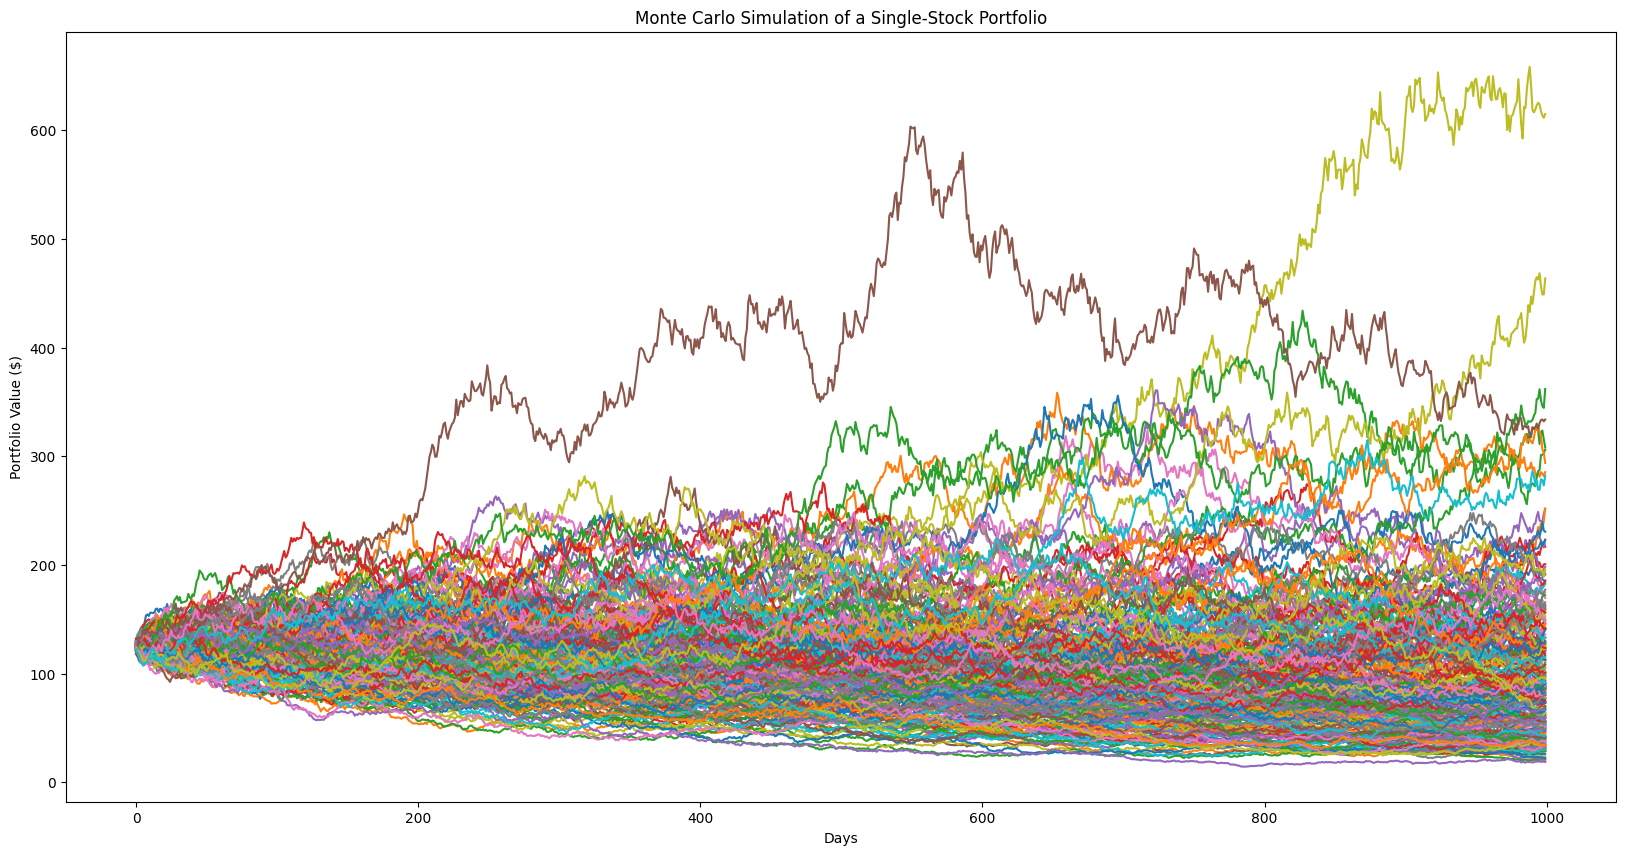

In [ ]:
# Define portfolio current value
current_value = portofolioPrices[-1] 
# Define mean and standard deviation of stock returns
mean_return = mean_ptf
std_return = std_ptf
# Define the number of simulations and time horizon
n_simulations = 1000
time_horizon = 250 # in days

# Generate random numbers for the stock returns
random_returns = np.random.normal(mean_return, std_return, size=(n_simulations, time_horizon))
# Calculate future portfolio values for each simulation
future_values = current_value * np.cumprod(1 +  random_returns, axis=0)

# Plot the Monte Carlo simulation results
plt.figure(figsize=(20, 10))
plt.plot(future_values)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('Monte Carlo Simulation of a Single-Stock Portfolio')
plt.show()

# Here we plot the portfolio fictive returns

In [ ]:
# Compute log returns
log_returns = [np.log((arr / (arr - 1))) for arr in future_values]

z_value = norm.ppf(1 - 0.05)
liste_var_x = []

for n,v in enumerate(log_returns):
  volatility_n = log_returns[n].std()
  VaR_X = z_value*volatility_n
  VaR_Dollar = future_values[n][-1]*VaR_X
  liste_var_x.append(VaR_X)

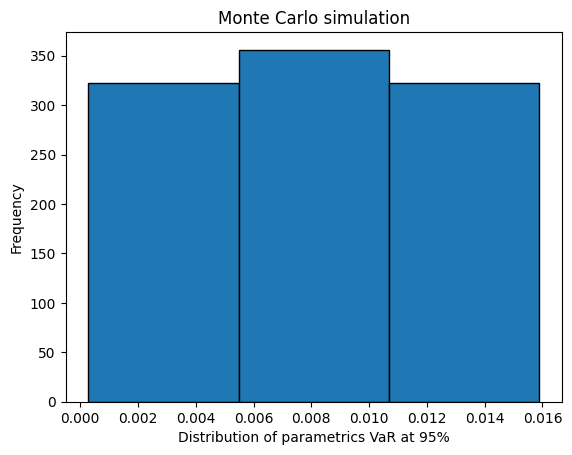

In [ ]:
# Plot the histogram
plt.hist(liste_var_x, bins=3, edgecolor='black')
plt.xlabel('Distribution of parametrics VaR at 95%')
plt.ylabel('Frequency')
plt.title('Monte Carlo simulation')
plt.show()

# In this example, we observe that most of the simulated VaR at 95% are in the interval [0.01 - 0.0175].

#4 weekly, monthly and annual VaR

In [ ]:
# Calculate the weekly, monthly and annual VaR (1%) from the daily VaR(1%) for all three historical based approaches.
liste_VaR = [SMA_var_doll, EWMA_var_doll, non_param_var_doll, hybrid_var_doll]
liste_VaR_str = ['SMA_var_doll', 'EWMA_var_doll', 'non_param_var_doll', 'hybrid_var_doll']

def week_month_ann_VaR(daily_VaR, VaR_name):
  w_var = daily_VaR*np.sqrt(5)
  m_var = daily_VaR*np.sqrt(20)
  a_var = daily_VaR*np.sqrt(250)
  print('The weekly VaR for ',VaR_name, 'is $',round(w_var,3))
  print('The monthly VaR for ',VaR_name, 'is $',round(m_var,3))
  print('The annual VaR for ',VaR_name, 'is $',round(a_var,3))
  print('--------------------------------------------')

for n,v in enumerate(liste_VaR):
  week_month_ann_VaR(liste_VaR[n], liste_VaR_str[n])

The weekly VaR for  SMA_var_doll is $ 12.813
The monthly VaR for  SMA_var_doll is $ 25.625
The annual VaR for  SMA_var_doll is $ 90.599
--------------------------------------------
The weekly VaR for  EWMA_var_doll is $ 10.129
The monthly VaR for  EWMA_var_doll is $ 20.259
The annual VaR for  EWMA_var_doll is $ 71.626
--------------------------------------------
The weekly VaR for  non_param_var_doll is $ 13.126
The monthly VaR for  non_param_var_doll is $ 26.251
The annual VaR for  non_param_var_doll is $ 92.813
--------------------------------------------
The weekly VaR for  hybrid_var_doll is $ 5.993
The monthly VaR for  hybrid_var_doll is $ 11.985
The annual VaR for  hybrid_var_doll is $ 42.375
--------------------------------------------


In [ ]:
#For the parametric models (SMA and EWMA) convert, as well, the VaR(1%) to VaR(5%).
SMA_VaR_5 = round(SMA_var_doll*1.65/2.33,2)
EWMA_VaR_5 = round(EWMA_var_doll*1.65/2.33,2)
print('The 95% confidence level daily VaR for SMA_var_doll is $', SMA_VaR_5, 'versus $', SMA_var_doll, 'for the 99% confidence level VaR')
print('The 95% confidence level daily VaR for EWMA_var_doll is $', EWMA_VaR_5, 'versus $', EWMA_var_doll, 'for the 99% confidence level VaR')

The 95% confidence level daily VaR for SMA_var_doll is $ 4.06 versus $ 5.73 for the 99% confidence level VaR
The 95% confidence level daily VaR for EWMA_var_doll is $ 3.21 versus $ 4.53 for the 99% confidence level VaR


#5 Expected Shortfall

Expected Shortfall, otherwise known as CVaR, or conditional value at risk, is simply the expected loss of the worst case scenarios of returns. For example, if your portfolio has a VaR(99) of -3%, then the CVaR(99) would be the average value of all losses exceeding -3%.

## Parametric approach

In [ ]:
#Calculate Expected Shortfall for the parametric and non-parametric approaches for the 5th percent quantile (=VaR (5%)). Explain the methodology. Comment and compare the results.

def compute_param_cvar(mu, sigma, x, y):
    z = stats.norm.ppf(x)
    numerator = math.exp((-z**2) / 2)
    denominator = (1 - y) * (np.sqrt(2 * np.pi))
    cvar = mu + sigma * (numerator/denominator)
    return cvar

# inputs
mu = 0 # Common assumption
sigma = volatility # Volatility was calculated in part 2
x = 0.95 #selected X% probability
y = 0.95 # Confidence interval

# Compute CVaR
cvar = round(compute_param_cvar(mu, sigma, x, y),4)

print('The average expected loss for a CVaR 5% is %', cvar*100, 'or $', round(list(portofolioPrices.values)[-1]*cvar,2))

The average expected loss for a CVaR 5% is % 4.03 or $ 5.08


## Non parametric approach

In [ ]:
def compute_nonparam_cvar(returns, confidence):
    n = len(returns)
    index = int((1 - x) * n)
    cvar = np.mean(np.sort(ptfReturns.values)[:index])
    return cvar

confidence = 0.95

cvar = round(abs(compute_nonparam_cvar(np.sort(ptfReturns), confidence)),3)
print('The average expected loss for a CVaR 5% is %', cvar*100, 'or $', round(list(portofolioPrices.values)[-1]*cvar,2))

The average expected loss for a CVaR 5% is % 4.3 or $ 5.42
